### Install Spark

In [ ]:
!scala -version

Scala code runner version 2.12.12 -- Copyright 2002-2020, LAMP/EPFL and Lightbend, Inc.


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder \
.appName('1.2. BigQuery Storage & Spark SQL - Python')\
.config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar') \
.getOrCreate()

### Import modules

In [ ]:
import time
from itertools import islice
from itertools import compress 

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
# import sh
from pyspark.sql.functions import *
#from pyspark.sql import functions as F
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
# warnings.filterwarnings(action='ignore')

In [ ]:
import sys
print(sys.version)
print(spark.version)

3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49) 
[GCC 7.5.0]
3.0.1


In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
# warnings.filterwarnings(action='ignore')

In [ ]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Set-up COS functions for GCS
from google.cloud import storage

### Define Helper Functions

In [ ]:
# List all files in given COS directory
def list_blobs(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        print(blob.name + '\t' + str(blob.size))

In [ ]:
# List all files in given COS directory in dataframe format
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns=['Name','Size'])

    blobs_df = blobs_df.style.format({"Size": "{:,.0f}"}) 
    
    return blobs_df

In [ ]:
# Delete folder from COS bucket
def delete_folder(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        blob.delete()

#### Add "eagerEval.enabled" to beautify the way Spark DF is displayed

In [ ]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

### Load Data

In [ ]:
# Reading data from open bucket
bucket_read = 'msca-bdp-tweets'

# Saving results into individual bucket
bucket_write = 'msca-bdp-students-bucket'

In [ ]:
tweets = spark.read.json('gs://' + bucket_write + '/shared/hedan/original_tweets')

## Step 3. Identify the most prolific / influential Twitterers 

### 3.1. Twitterers Profile

In [ ]:
tweets.groupBy('user_identification').agg(countDistinct('user_id_str').alias('account_count')).orderBy('account_count',ascending=False)

user_identification,account_count
other,3392920
news,11043
social_media_infl...,9295
health,2386
government,749


In [ ]:
verified = tweets.filter(tweets.user_verified == 'true')

In [ ]:
verified.count()

481827

### 3.2. Find the most influencing Twitterers 

#### 3.2.1. By message volume (original content)

In [ ]:
original = tweets.filter(tweets.original_ret_id_str.isNull()&tweets.original_quo_id_str.isNull())

In [ ]:
original_tweets = original.count()
original_tweets

4440179

In [ ]:
original.filter(original.user_verified == 'true').count()

301625

In [ ]:
original.groupby('user_identification').agg(countDistinct('user_id_str').alias('user_count'))

user_identification,user_count
news,7812
other,1425719
social_media_infl...,6141
health,1916
government,485


In [ ]:
message_volume = original.groupby('user_id_str').agg(countDistinct('id_str').alias('original_volume')).orderBy('original_volume',ascending=False)

In [ ]:
message_volume.limit(30)

user_id_str,original_volume
3219670842,15340
728894570,4970
1283765688616628233,4680
1269612893529444354,4512
1015456945447170048,4337
1236273574895329281,3683
1269773684518146052,3575
1191745846615957506,2812
192969056,2756
1398687202507472904,2643


In [ ]:
twitterers = tweets.select('user_id_str','user_name','user_identification').dropDuplicates(['user_id_str'])

In [ ]:
top_tweeterers_original_volume = message_volume.join(twitterers,['user_id_str'],how="inner")

In [ ]:
# add
#top100_twitterers_volume = top_tweeterers_original_volume.orderBy('original_volume',ascending=False).limit(100)

In [ ]:
#top100_twitterers_volume.groupby('user_identification').agg(count('user_id_str').alias('twitterers_count'))
# stop

In [ ]:
top30_twitterers_volume = top_tweeterers_original_volume.orderBy('original_volume',ascending=False).limit(30)

In [ ]:
verified.groupby('user_identification').agg(countDistinct('user_id_str').alias('twitterers_count'))

user_identification,twitterers_count
news,11043
other,38855
social_media_infl...,6120
health,2386
government,749


#### Use original_tweet method

In [ ]:
# twiterers_original_volume = tweets.groupby('original_retaccount_id_str').agg(countDistinct('original_ret_id_str').alias('original_volume')).orderBy('original_volume',ascending=False)

In [ ]:
# twiterers_original_volume.limit(30)

In [ ]:
original_twitterers = tweets.select('original_retaccount_id_str','original_retaccount_name','ori_identification').dropDuplicates(['original_retaccount_id_str'])

In [ ]:
# top_tweeterers_original_volume_2 = twiterers_original_volume.join(original_twitterers,['original_retaccount_id_str'],how="inner")

In [ ]:
# top30_twitterers_volume_2 = top_tweeterers_original_volume_2.orderBy('original_volume',ascending=False).limit(30)

In [ ]:
# top30_twitterers_volume_2.toPandas()

#### 3.2.2. By message retweet

In [ ]:
twiterers_retweet_count = tweets.groupby('original_retaccount_id_str','original_ret_id_str').agg(max('original_retweet_count').alias('retweet_count')).orderBy('retweet_count',ascending=False)

In [ ]:
twiterers_retweet_count.limit(30)

original_retaccount_id_str,original_ret_id_str,retweet_count
183160736,1243427980199641088,362880
92717138,1239617034901524481,281546
461922813,1309142915210506244,228965
933128688,1312915126215864320,221184
871206082626158592,1282472421925294080,206881
466519303,1238545438476730369,190519
953557670103076864,1264298591855579136,178089
894172301905625088,1239998469948858368,175819
63487085,1241025578527903750,169838
803113506153369601,1274078367877300227,165850


In [ ]:
twitterers_retweet = twiterers_retweet_count.groupby('original_retaccount_id_str').agg(sum('retweet_count').alias('overall_retweet_count')).orderBy('overall_retweet_count')

In [ ]:
top_tweeterers_retweet = twitterers_retweet.join(original_twitterers,['original_retaccount_id_str'],how='inner')

In [ ]:
top30_twitterers_retweet = top_tweeterers_retweet.orderBy('overall_retweet_count',ascending=False).limit(30)

#### 3.2.3. By combination of original count and retweet count

In [ ]:
influencing_twitterers = tweets.withColumn('tweet_weight',when(tweets.original_ret_id_str.isNull()&tweets.original_quo_id_str.isNull(),3).otherwise(1))

In [ ]:
influencing_twitterers_2 = influencing_twitterers.groupby('user_id_str').agg(sum('tweet_weight').alias('tweets_score'))

In [ ]:
user_tweets = tweets.select('user_id_str','user_name','user_identification').dropDuplicates(['user_id_str'])

In [ ]:
influencing_twitterers_3 = influencing_twitterers_2.join(user_tweets,['user_id_str'],how='inner')

In [ ]:
top30_twitterers_weight = influencing_twitterers_3.orderBy('tweets_score',ascending=False).limit(30)

### 3.3. Distribution of Tweet/Retweet by Twitterers and types of organizations

In [ ]:
temp1 = top30_twitterers_volume.toPandas()

In [ ]:
temp1

,user_id_str,original_volume,user_name,user_identification
0,3219670842,15340,Nathan Joyner,other
1,728894570,4970,iWeller.com,other
2,1283765688616628233,4680,Galla Go,other
3,1269612893529444354,4512,News Bht,other
4,1015456945447170048,4337,hiremaid.com.sg,other
5,1236273574895329281,3683,Coronavirus Updates,other
6,1269773684518146052,3575,Jeremy Hume,other
7,1191745846615957506,2812,Paperbirds_Coronavirus,other
8,192969056,2756,Workout Solutions ☦️🌸,other
9,1398687202507472904,2643,TittlePress,other


<AxesSubplot:title={'center':'Top 30 Prolific Twitterers'}, xlabel='user_name'>

/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127800 missing from current font.
  font.set_text(s, 0, flags=flags)


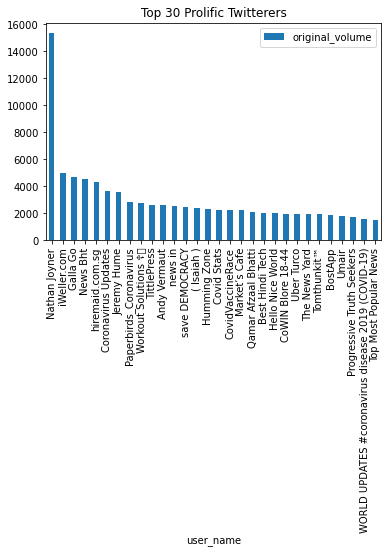

In [ ]:
temp1.plot(kind='bar',x='user_name',y='original_volume',legend='None',title='Top 30 Prolific Twitterers')

In [ ]:
temp2 = top30_twitterers_retweet.toPandas()

In [ ]:
temp2 

,original_retaccount_id_str,overall_retweet_count,original_retaccount_name,ori_identification
0,18831926,584646,Eric Feigl-Ding,health
1,39844876,445707,"Robert W Malone, MD",social_media_influencer
2,707231479047315456,435068,PeterSweden,social_media_influencer
3,1349149096909668363,419222,President Biden,social_media_influencer
4,183160736,362880,Sir Mo,other
5,878284831,355981,Occupy Democrats,social_media_influencer
6,878247600096509952,298299,Candace Owens,social_media_influencer
7,18839785,282013,Narendra Modi,social_media_influencer
8,92717138,281546,Idris Elba,social_media_influencer
9,15392486,255979,Disclose.tv,social_media_influencer


<AxesSubplot:title={'center':'Top 30 Influencing Twitterers by Retweet Count'}, xlabel='original_retaccount_name'>

/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127769 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:20

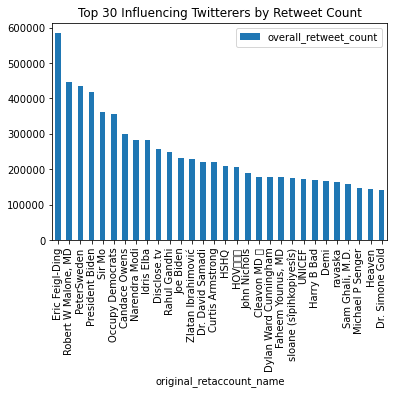

In [ ]:
temp2.plot(kind='bar',x='original_retaccount_name',y='overall_retweet_count',legend='None',title='Top 30 Influencing Twitterers by Retweet Count')

In [ ]:
temp6 = top30_twitterers_weight.toPandas()

In [ ]:
temp6

,user_id_str,tweets_score,user_name,user_identification
0,3219670842,46047,Nathan Joyner,other
1,1015456945447170048,15413,hiremaid.com.sg,other
2,728894570,14913,iWeller.com,other
3,952247125185720320,14057,#StayHome,other
4,1283765688616628233,14043,Galla Go,other
5,1269612893529444354,13536,News Bht,other
6,1236273574895329281,11052,Coronavirus Updates,other
7,1269773684518146052,10725,Jeremy Hume,other
8,192969056,8895,Workout Solutions ☦️🌸,other
9,1191745846615957506,8436,Paperbirds_Coronavirus,other


<AxesSubplot:title={'center':'Top 30 Influencing Twitterers by Weighted Tweets Count'}, xlabel='user_name'>

/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129302 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127800 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 129302 missing from current font.
  font.set_text(s, 0, flags=flags)


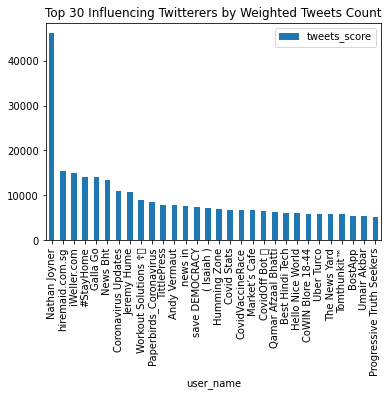

In [ ]:
temp6.plot(kind='bar',x='user_name',y='tweets_score',legend='None',title='Top 30 Influencing Twitterers by Weighted Tweets Count')

In [ ]:
organization_tweetsvolume = tweets.groupby('user_identification').agg(countDistinct('id_str').alias('tweet_volume')).orderBy('tweet_volume',ascending=False)

In [ ]:
temp3 = organization_tweetsvolume.toPandas()

In [ ]:
temp3

,user_identification,tweet_volume
0,other,17121060
1,news,167232
2,social_media_influencer,103050
3,health,38110
4,government,4738


In [ ]:
# temp3.plot(kind='bar',x='user_identification',y='tweet_volume',legend='None',title='Distribution of Tweet by Types of Organizations')

In [ ]:
organization_retweetsvolume = top_tweeterers_retweet.groupby('ori_identification').agg(sum('overall_retweet_count').alias('retweet_volume')).orderBy('retweet_volume',ascending=False)

In [ ]:
temp4 = organization_retweetsvolume.toPandas()

In [ ]:
temp4

,ori_identification,retweet_volume
0,other,26954155
1,social_media_influencer,20642898
2,news,2884720
3,health,1765407
4,government,340570


<AxesSubplot:title={'center':'Distribution of Retweet by Types of Organizations'}, xlabel='ori_identification'>

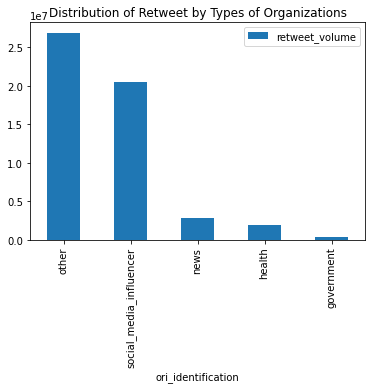

In [ ]:
temp4.plot(kind='bar',x='ori_identification',y='retweet_volume',legend='None',title='Distribution of Retweet by Types of Organizations')

## Step 4. Where are these Twitterers located?

### 4.1. Find out the top countries and places where Twitterers locate

In [ ]:
twitterer_location = tweets.filter(tweets.user_location.isNotNull()).groupBy('user_location').\
agg(countDistinct('user_id_str').alias('user_count')).orderBy('user_count',ascending=False)

In [ ]:
top30_locations = twitterer_location.limit(30)

In [ ]:
temp5 = top30_locations.toPandas()
temp5

,user_location,user_count
0,United States,34279
1,"London, England",18157
2,India,14427
3,"Los Angeles, CA",14361
4,London,13957
5,"California, USA",12746
6,United Kingdom,12180
7,USA,11516
8,Canada,11282
9,"Chicago, IL",11278


<AxesSubplot:title={'center':'Top 30 Locations of Twitterers'}, ylabel='user_location'>

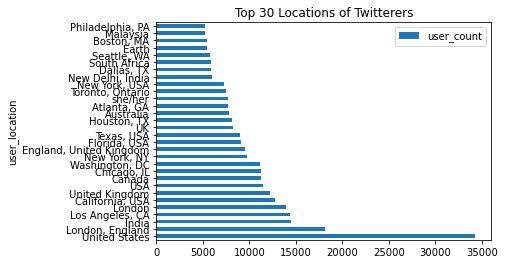

In [ ]:
temp5.plot(kind='barh',x='user_location',y='user_count',legend='None',title='Top 30 Locations of Twitterers')

In [ ]:
# tweets.filter(tweets.country.isNotNull()&tweets.country_code.isNotNull()&tweets.place_name.isNotNull()\
   #           &tweets.place_full_name.isNotNull()&tweets.place_type.isNotNull()).\
# select('user_id_str','user_location','id_str','country','country_code','place_name','place_full_name','place_type').limit(20)

In [ ]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [ ]:
coordinates = tweets.filter(tweets.coordinates.isNotNull()).select('user_id_str','coordinates').dropDuplicates(['user_id_str'])

In [ ]:
coordinates = coordinates.toPandas()

In [ ]:
longitude = []
latitude = []
for i in coordinates['coordinates']:
  longitude.append(i[0])
  latitude.append(i[1])

In [ ]:
coordinates['longitude'] = longitude
coordinates['latitude'] = latitude
coordinates = coordinates.drop(columns = 'coordinates')

In [ ]:
geo_distribution = [Point(xy) for xy in zip(coordinates['longitude'],coordinates['latitude'])]
geo_data = GeoDataFrame(coordinates,geometry = geo_distribution)

<AxesSubplot:>

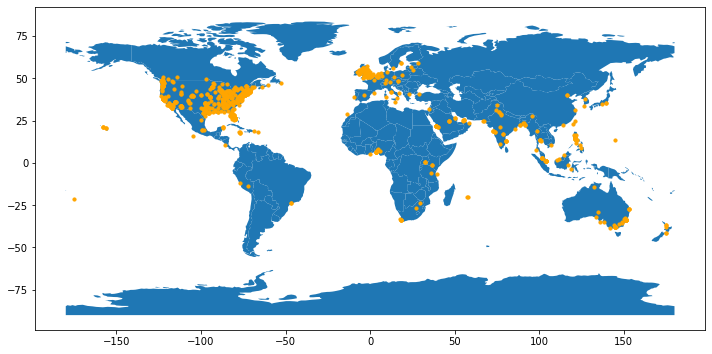

In [ ]:
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geo_data.plot(ax=world_map.plot(figsize=(12,8)),marker='o',markersize=10,color='orange')

### Location of Tweets

In [ ]:
tweets_place = tweets.filter(tweets.place_name.isNotNull()).groupBy('place_name').agg(count('id_str').alias('tweets_count')).\
orderBy('tweets_count',ascending=False)

In [ ]:
top30_tweets_places = tweets_place.limit(30)

In [ ]:
ttp = top30_tweets_places.toPandas()
ttp

,place_name,tweets_count
0,Los Angeles,1179
1,Toronto,935
2,Melbourne,896
3,Manhattan,884
4,Florida,825
5,Washington,699
6,Chicago,696
7,Sydney,541
8,Auckland,535
9,Pennsylvania,522


In [ ]:
#x_2 = tl3.place_name
#y_2 = tl3.tweets_count

In [ ]:
#plt.bar(x_2,y_2)
#plt.title(label='Top Locations of Tweets',fontsize=10)
#plt.xticks(rotation=45,fontsize=5)
#plt.figure(figsize=(50,20))

<AxesSubplot:title={'center':'Top 30 Places of Tweets'}, ylabel='place_name'>

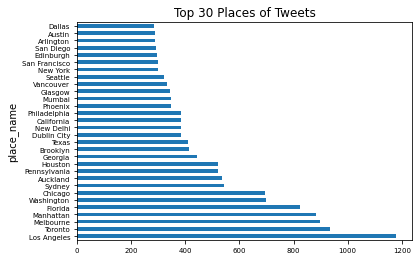

In [ ]:
ttp.plot(kind='barh',x='place_name',y='tweets_count',legend=None,fontsize=7,title='Top 30 Places of Tweets')

In [ ]:
tweets.filter(tweets.country.isNotNull()).count()

80888

In [ ]:
tweets_country = tweets.filter(tweets.country.isNotNull()).groupBy('country').agg(count('id_str').alias('tweets_count')).\
orderBy('tweets_count',ascending=False)

In [ ]:
top30_tweets_country = tweets_country.limit(30)

In [ ]:
ttc = top30_tweets_country.toPandas()
ttc

,country,tweets_count
0,United States,40716
1,United Kingdom,15105
2,Canada,4904
3,India,3668
4,Australia,3206
5,Ireland,1652
6,New Zealand,1473
7,South Africa,1251
8,Republic of the Philippines,538
9,Spain,353


<AxesSubplot:title={'center':'Top 30 Countries of Tweets'}, ylabel='country'>

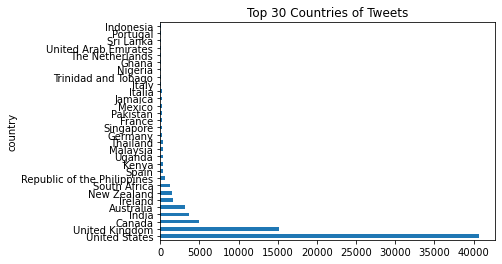

In [ ]:
ttc.plot(kind='barh',x='country',y='tweets_count',legend=None,title='Top 30 Countries of Tweets')

### 4.2. Relationship between the pandemic progression and locations of these Twitterers

#### replace user_country by country

In [ ]:
tweets_user_country_2 = tweets.filter(tweets.country.isNotNull()).groupBy('country').\
agg(countDistinct('user_id_str').alias('user_count')).orderBy('user_count',ascending=False)

In [ ]:
top50_countries = tweets_user_country_2.limit(50).toPandas()

In [ ]:
top50_countries

,country,user_count
0,United States,22917
1,United Kingdom,7958
2,Canada,2247
3,India,2102
4,Australia,1368
5,Ireland,802
6,South Africa,800
7,New Zealand,448
8,Republic of the Philippines,327
9,Uganda,223


<AxesSubplot:title={'center':'Top 50 Countries of Twitterers'}, ylabel='country'>

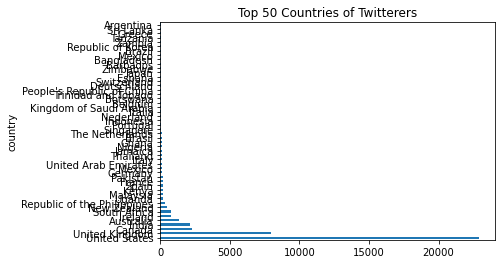

In [ ]:
top50_countries.plot(kind='barh',x='country',y='user_count',legend=None,title='Top 50 Countries of Twitterers')

### 4.3. Combined with Covid Data

In [ ]:
tweets_user_country_code = tweets.filter(tweets.country_code.isNotNull()).groupBy('country_code').\
agg(countDistinct('user_id_str').alias('user_count')).orderBy('user_count',ascending=False)

In [ ]:
from pyspark.sql.functions import substring

In [ ]:
tweets_time = tweets.withColumn("created_year",substring(tweets['created_at'],27,4)).\
withColumn("created_month",substring(tweets['created_at'],5,3)).\
withColumn("created_date",substring(tweets['created_at'],9,2)).\
withColumn("created_hour",substring(tweets['created_at'],12,2)).\
withColumn("time",concat(col('created_year'),lit('-'),col('created_month'),lit('-'),col('created_date'),lit('-'),col('created_hour'))).\
withColumn("created_month_num",when(col("created_month")=='Oct',10).otherwise(11)).\
withColumn("date",concat(col('created_year'),lit('-'),col('created_month_num'),lit('-'),col('created_date')))

In [ ]:
covid = spark.read.csv('gs://msca-bdp-students-bucket/notebooks/hedan/final/covid_all.csv',header=True)

In [ ]:
covid.printSchema()

root
 |-- date: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- country: string (nullable = true)
 |-- New_cases: integer (nullable = true)
 |-- Cumulative_cases: integer (nullable = true)
 |-- New_deaths: integer (nullable = true)
 |-- Cumulative_deaths: integer (nullable = true)



In [ ]:
covid = covid.withColumn('New_cases',covid['New_cases'].cast(IntegerType())).\
withColumn('Cumulative_cases',covid['Cumulative_cases'].cast(IntegerType())).\
withColumn('New_deaths',covid['New_deaths'].cast(IntegerType())).\
withColumn('Cumulative_deaths',covid['Cumulative_deaths'].cast(IntegerType()))

In [ ]:
covid_change = covid.groupBy('country_code').agg(sum('New_cases').alias('period_new_cases'),sum('New_deaths').alias('period_new_deaths'),\
                                              ((max(col('Cumulative_cases'))-min(col('Cumulative_cases')))/min(col('Cumulative_cases'))).alias('case_growth_rate'),\
                                             ((max(col('Cumulative_deaths'))-min(col('Cumulative_deaths')))/min(col('Cumulative_deaths'))).alias('death_growth_rate'))

In [ ]:
covid_twitterers = covid_change.join(tweets_user_country_code,['country_code'],how='inner')

In [ ]:
covid_twitterers.count()

187

In [ ]:
covid_twitterers.corr('period_new_cases','user_count')

0.7979978873301011

In [ ]:
covid_twitterers.corr('period_new_deaths','user_count')

0.6458183856722844

In [ ]:
pd_covid_twitterers = covid_twitterers.orderBy('user_count',ascending=False).limit(50).toPandas()

In [ ]:
pd_covid_twitterers

,country_code,period_new_cases,period_new_deaths,case_growth_rate,death_growth_rate,user_count
0,US,1996310,33817,0.042674,0.044779,22960
1,GB,1088562,4101,0.124898,0.028610,7988
2,CA,67155,850,0.038234,0.028007,2251
3,IN,364078,10375,0.010222,0.022587,2126
4,AU,47903,362,0.326964,0.233732,1368
5,IE,69507,260,0.163571,0.049001,804
6,ZA,9795,929,0.003108,0.009858,800
7,NZ,3205,5,0.690981,0.178571,451
8,PH,111042,4444,0.038266,0.104913,329
9,ES,54746,407,0.010561,0.004478,257


In [ ]:
pd_covid_twitterers.plot(kind='bar',x='country_code',y=['period_new_cases','user_count'],fontsize=7,title='Relationship between New Cases and Twitterers')

#### Take several countries as examples to see the relationship between case and tweets

In [ ]:
tweets_country_date = tweets_time.groupby("date","country_code").agg(countDistinct('id_str').alias('tweets_count'))

In [ ]:
case_tweets = tweets_country_date.join(covid,['date','country_code'],how='inner')

In [ ]:
#United States
us_case_tweets = case_tweets.filter(case_tweets.country_code=='US').select('date','tweets_count','New_cases').orderBy('date')

In [ ]:
us_case_tweets.toPandas()

,date,tweets_count,New_cases
0,2021-10-16,1211,96747
1,2021-10-17,1096,91573
2,2021-10-18,2291,62761
3,2021-10-19,1735,49176
4,2021-10-20,1692,70432
5,2021-10-21,1529,81289
6,2021-10-22,1348,76691
7,2021-10-23,1032,87413
8,2021-10-24,980,80738
9,2021-10-25,1364,29892


In [ ]:
us_case_tweets.corr('tweets_count','New_cases')

-0.04777864039145214

In [ ]:
#Canada
ca_case_tweets = case_tweets.filter(case_tweets.country_code=='CA').select('date','tweets_count','New_cases').orderBy('date')

In [ ]:
ca_case_tweets.toPandas()

,date,tweets_count,New_cases
0,2021-10-16,166,3174
1,2021-10-17,136,3438
2,2021-10-18,237,3347
3,2021-10-19,181,2894
4,2021-10-20,203,2255
5,2021-10-21,224,2275
6,2021-10-22,222,2641
7,2021-10-23,163,2894
8,2021-10-24,144,2762
9,2021-10-25,161,2551


In [ ]:
ca_case_tweets.corr('tweets_count','New_cases')

-0.2454917087071485

In [ ]:
#United Kingdom
uk_case_tweets = case_tweets.filter(case_tweets.country_code=='GB').select('date','tweets_count','New_cases').orderBy('date')

In [ ]:
uk_case_tweets.toPandas()

,date,tweets_count,New_cases
0,2021-10-16,477,44212
1,2021-10-17,445,42818
2,2021-10-18,582,44696
3,2021-10-19,773,48703
4,2021-10-20,1075,43324
5,2021-10-21,968,48545
6,2021-10-22,718,51484
7,2021-10-23,587,48728
8,2021-10-24,502,44985
9,2021-10-25,478,38740


In [ ]:
uk_case_tweets.corr('tweets_count','New_cases')

0.46596918160291145

In [ ]:
#Australia
au_case_tweets = case_tweets.filter(case_tweets.country_code=='AU').select('date','tweets_count','New_cases').orderBy('date')

In [ ]:
au_case_tweets.toPandas()

,date,tweets_count,New_cases
0,2021-10-16,172,2556
1,2021-10-17,134,2271
2,2021-10-18,158,2115
3,2021-10-19,118,2151
4,2021-10-20,134,2020
5,2021-10-21,171,2052
6,2021-10-22,144,2643
7,2021-10-23,122,2322
8,2021-10-24,143,2041
9,2021-10-25,103,2160


In [ ]:
au_case_tweets.corr('tweets_count','New_cases')

0.6108150616986174

In [ ]:
#India
in_case_tweets = case_tweets.filter(case_tweets.country_code=='IN').select('date','tweets_count','New_cases').orderBy('date')

In [ ]:
in_case_tweets.toPandas()

,date,tweets_count,New_cases
0,2021-10-16,82,15981
1,2021-10-17,131,14146
2,2021-10-18,133,13596
3,2021-10-19,120,13058
4,2021-10-20,137,14623
5,2021-10-21,491,18454
6,2021-10-22,307,15786
7,2021-10-23,224,16326
8,2021-10-24,155,15906
9,2021-10-25,101,14306


In [ ]:
in_case_tweets.corr('tweets_count','New_cases')

0.6649118254003117

## Step 5. What are the timelines of these tweets? Any significant peaks and valleys? 

In [ ]:
# tweets_time.printSchema()

In [ ]:
tweet_time_2 = tweets_time.groupby('date').agg(count('id_str').alias('tweets_count'))

In [ ]:
tt2 = tweet_time_2.orderBy('date',ascending=True).toPandas()

In [ ]:
tt2

,date,tweets_count
0,2021-10-15,567533
1,2021-10-16,536810
2,2021-10-17,506279
3,2021-10-18,873664
4,2021-10-19,780644
5,2021-10-20,823615
6,2021-10-21,761586
7,2021-10-22,664621
8,2021-10-23,512016
9,2021-10-24,499186


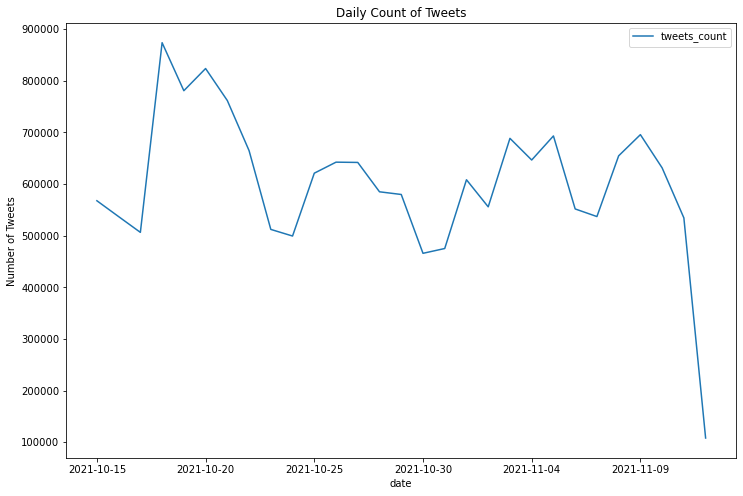

In [ ]:
tt2.plot(x='date',y='tweets_count',figsize=(12,8),title='Daily Count of Tweets')
plt.ylabel("Number of Tweets")
plt.show()

In [ ]:
tt3 = tweet_time_2.orderBy('tweets_count',ascending=False).toPandas()

In [ ]:
tt3

,date,tweets_count
0,2021-10-18,873664
1,2021-10-20,823615
2,2021-10-19,780644
3,2021-10-21,761586
4,2021-11-09,695554
5,2021-11-05,693059
6,2021-11-03,688392
7,2021-10-22,664621
8,2021-11-08,654531
9,2021-11-04,646420


In [ ]:
covid_daily = covid.groupby('date').agg(sum('New_cases').alias('world_new_cases'),sum('New_deaths').alias('world_death_cases'))

In [ ]:
covid_tweets = tweet_time_2.join(covid_daily,['date'],how='left')

In [ ]:
covid_tweets.orderBy('date').toPandas()

,date,tweets_count,world_new_cases,world_death_cases
0,2021-10-15,567533,NaN,NaN
1,2021-10-16,536810,443256.0,6787.0
2,2021-10-17,506279,411394.0,6838.0
3,2021-10-18,873664,345923.0,5376.0
4,2021-10-19,780644,356410.0,5504.0
5,2021-10-20,823615,428027.0,7768.0
6,2021-10-21,761586,458747.0,7181.0
7,2021-10-22,664621,464064.0,7472.0
8,2021-10-23,512016,473871.0,7516.0
9,2021-10-24,499186,427298.0,7156.0


## Step 6. How unique are the messages?

In [ ]:
text_spark = tweets.select(['text','user_verified','user_identification','id_str']).dropna()

In [ ]:
text_spark.write.format("json").mode("overwrite").save('gs://' + bucket_write + '/shared/hedan/text_tweets_3')

In [ ]:
# text_spark = spark.read.json('gs://' + bucket_write + '/shared/hedan/text_tweets_3')

In [ ]:
# text_spark.printSchema()

### 6.3. Message Duplication for health organizations group

#### 6.3.1. Health Organization

In [ ]:
df_text_raw = tweets.filter(tweets.user_identification=='health').select(["text"]).dropna()

In [ ]:
text = df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [ ]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])

In [ ]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

In [ ]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [ ]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [ ]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [ ]:
df_dups_50 = df_dups_text
df_dups_text.cache()

distCol,id_A,id_B,text_A,text_B
0.11111111111111116,31954,34383,[*Reminder* 📢 pa...,[*Reminder* 📢 pa...
0.11111111111111116,10383,17649,[Unvaccinated Gre...,[Unvaccinated Gre...
0.09090909090909094,7714,16574,[Two types of #CO...,[Two types of #CO...
0.26086956521739135,10321,22992,[A study reported...,[RT @VDHgov: A st...
0.0,11764,30390,[RT @NHSEngland: ...,[RT @NHSEngland: ...
0.29166666666666663,11584,35481,[Flu and COVID-19...,[Flu and COVID-19...
0.0,94,16273,[RT @NHSEngland: ...,[RT @NHSEngland: ...
0.20833333333333337,4284,19746,[Flu and COVID-19...,[RT @letstalkcent...
0.18181818181818177,1821,3568,[Flu and COVID-19...,[🦠 Flu and COVID...
0.09090909090909094,21113,34874,[Have you had you...,[Have you had you...


In [ ]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  38129
Duplicate titles based on { 0.5 } jaccard distance:  13193
Unique titles based on { 0.5 } jaccard distance:  0.5 :  24936


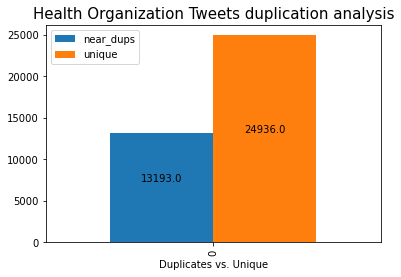

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Health Organization Tweets duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### 6.3.2. News Outlets

In [ ]:
df_text_raw = tweets.filter(tweets.user_identification=='news').select(["text","id_str"]).dropna()

In [ ]:
text = df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [ ]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])

In [ ]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

In [ ]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [ ]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [ ]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [ ]:
df_dups_50 = df_dups_text
df_dups_text.cache()

distCol,id_A,id_B,text_A,text_B
0.3157894736842105,75497,107452,[5/5 – Three Régi...,[4/4 – Three Régi...
0.25,55288,82448,[RT @ellengilmer:...,"[From DHS: ""Secre..."
0.05555555555555558,11873,18799,[These are the la...,[These are the la...
0.25,66382,156838,[Reports: FDA exp...,[Reports: FDA exp...
0.4666666666666667,130791,165724,[FDA to allow ‘mi...,[F.D.A. to Allow ...
0.47058823529411764,86404,102520,[RT @LoraLavigneT...,[FDA to allow ‘mi...
0.15384615384615385,66516,151533,[Why COVID-19 vac...,[Why COVID-19 vac...
0.10526315789473684,127509,135220,[The move would m...,[The move would m...
0.1333333333333333,16517,16518,[Side effects of ...,[Side effects of ...
0.3157894736842105,142560,142565,[The federal priv...,[RT @JimBronskill...


In [ ]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  167314
Duplicate titles based on { 0.5 } jaccard distance:  70404
Unique titles based on { 0.5 } jaccard distance:  0.5 :  96910


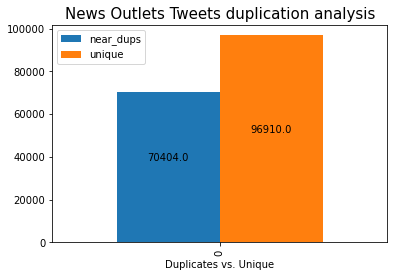

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News Outlets Tweets duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### 6.3.3. Government

In [ ]:
df_text_raw = text_spark.filter(text_spark.user_identification=='government').select(["text","id_str"]).dropna()

In [ ]:
text = df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [ ]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])

In [ ]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

In [ ]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [ ]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [ ]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [ ]:
df_dups_50 = df_dups_text
df_dups_text.cache()

distCol,id_A,id_B,text_A,text_B
0.4,910,2633,[October 26 @LNKh...,[October 19 @LNKh...
0.47619047619047616,804,2115,[#COVID19SK Summa...,[#COVID19SK Summa...
0.33333333333333337,1675,3639,[@WHOIraq daily C...,[@WHOIraq Daily C...
0.09090909090909094,3360,3856,[Is Europe in goo...,[Is Europe in goo...
0.36363636363636365,1591,1751,[As of 10-18-21 t...,[As of 11-02-21 t...
0.4347826086956522,521,1286,[As of 10-27-21 t...,[As of 10-16-21 t...
0.36363636363636365,811,1286,[As of 10-25-21 t...,[As of 10-16-21 t...
0.09999999999999998,1532,3354,[There are two es...,[There are two es...
0.09999999999999998,4268,4286,[Wearing a face c...,[Wearing a face c...
0.09090909090909094,2946,4694,[There are steps ...,[There are steps ...


In [ ]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  4743
Duplicate titles based on { 0.5 } jaccard distance:  1033
Unique titles based on { 0.5 } jaccard distance:  0.5 :  3710


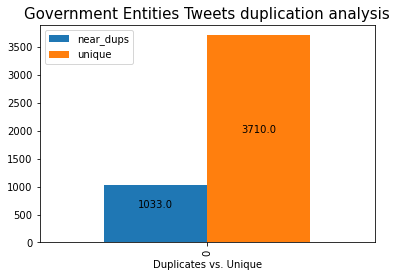

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Government Entities Tweets duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### 6.3.4. Social Media Influencers

In [ ]:
df_text_raw = text_spark.filter(text_spark.user_identification=='social_media_influencer').select(["text"]).dropna()

In [ ]:
text = df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [ ]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])

In [ ]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

In [ ]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [ ]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [ ]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [ ]:
df_dups_50 = df_dups_text
df_dups_text.cache()

distCol,id_A,id_B,text_A,text_B
0.0,1563,87030,[RT @narendramodi...,[RT @narendramodi...
0.0,53768,73935,[RT @narendramodi...,[RT @narendramodi...
0.0,130,51999,[RT @narendramodi...,[RT @narendramodi...
0.0,130,14236,[RT @narendramodi...,[RT @narendramodi...
0.0,70,17761,[RT @narendramodi...,[RT @narendramodi...
0.0,993,73935,[RT @narendramodi...,[RT @narendramodi...
0.0,993,70985,[RT @narendramodi...,[RT @narendramodi...
0.0,125,401,[RT @narendramodi...,[RT @narendramodi...
0.0,56802,56938,[RT @POTUS: We ha...,[RT @POTUS: We ha...
0.25,25452,80995,[Can at-home COVI...,[Can at-home COVI...


In [ ]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  103094
Duplicate titles based on { 0.5 } jaccard distance:  39500
Unique titles based on { 0.5 } jaccard distance:  0.5 :  63594


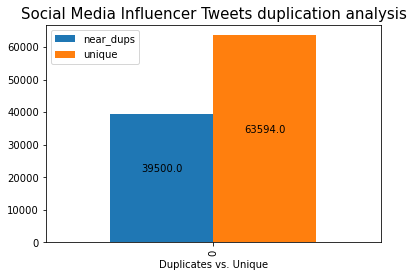

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Social Media Influencer Tweets duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 